In [22]:
!git clone https://github.com/rslim087a/track


Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163 (from 1)
Receiving objects: 100% (12163/12163), 156.98 MiB | 23.70 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [23]:
!ls

sample_data  track


In [24]:
!ls track


driving_log.csv  IMG


In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
import pandas as pd
import ntpath
import random


In [26]:
datadir = 'track'
columns = ["center","left","right","steering","throttle","reverse","speed"]
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [27]:
import ntpath

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()


,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


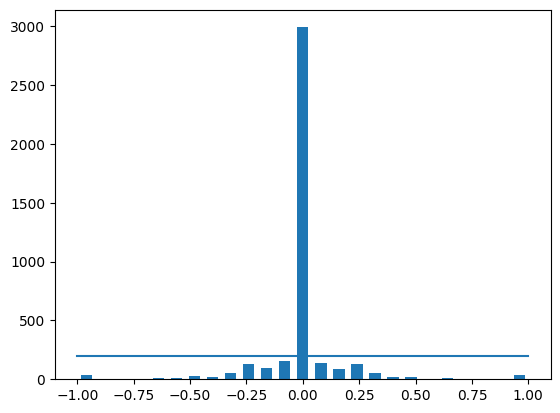

In [28]:
num_bins = 25
samples_per_bin = 200
hist,bins = np.histogram(data['steering'],num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


Total data: 4053
Removed: 2790
Remaining: 1263


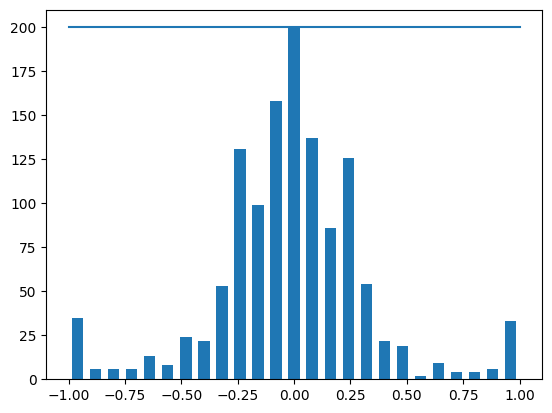

In [29]:
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

print('Total data:', len(data))

remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('Removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('Remaining:', len(data))

hist_, bins_ = np.histogram(data['steering'], num_bins)
center = (bins_[:-1] + bins_[1:]) * 0.5
plt.bar(center, hist_, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),
         (samples_per_bin, samples_per_bin))
plt.show()


In [30]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

center      center_2018_07_16_17_11_44_413.jpg
left          left_2018_07_16_17_11_44_413.jpg
right        right_2018_07_16_17_11_44_413.jpg
steering                                 -0.05
throttle                              0.642727
reverse                                    0.0
speed                                 1.434013
Name: 12, dtype: object
Training Samples: 1010
Valid Samples: 253


<ipython-input-30-cb091588cc9e>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
<ipython-input-30-cb091588cc9e>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))


Text(0.5, 1.0, 'Validation set')

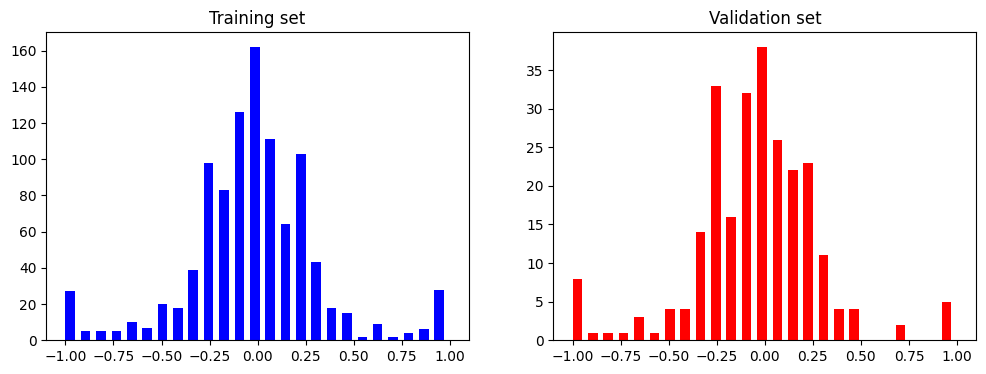

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')


Text(0.5, 1.0, 'Preprocessed Image')

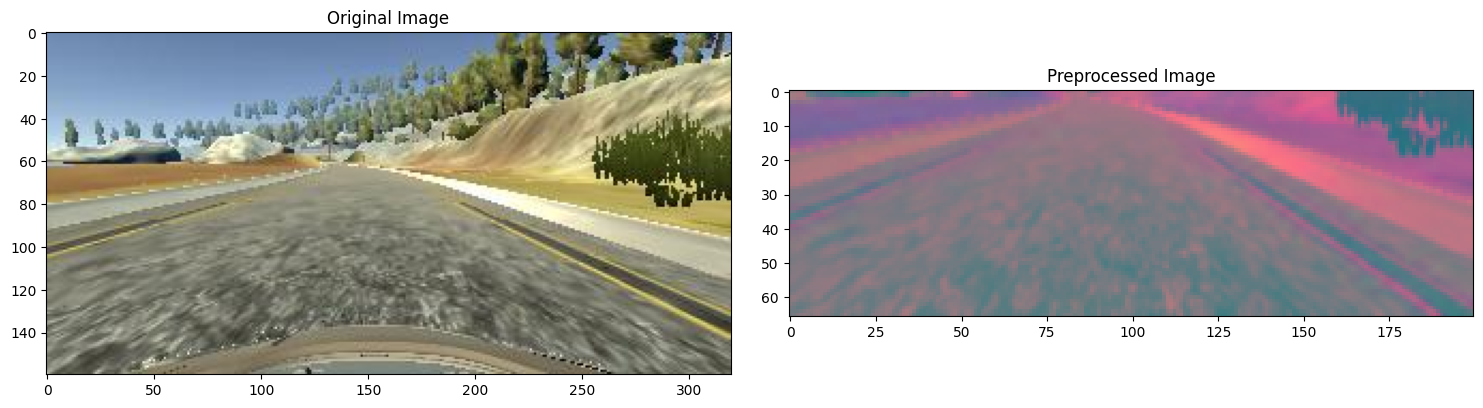

In [32]:
def img_preprocess(img):
   img = mpimg.imread(img)
   img = img[ 60:135:,:]
   img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
   img = cv2.GaussianBlur(img,(3,3),0)
   img =  cv2.resize(img,(200,66))
   img = img/255
   return img

image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig,axs = plt.subplots(1,2,figsize = (15,20))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [33]:
X_train = np.array(list(map(img_preprocess,X_train)))
X_valid = np.array(list(map(img_preprocess,X_valid)))


(1010, 66, 200, 3)


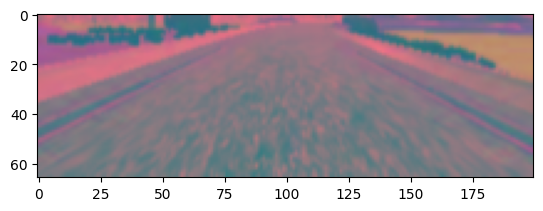

In [34]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
print(X_train.shape)

In [48]:
def nvidia_model():

  model = Sequential()

  from keras.layers import Input

  model = Sequential()
  model.add(Input(shape=(66, 200, 3)))
  model.add(Conv2D(24, (5, 5), strides=(2, 2)))


  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))


  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(learning_rate=0.001)

  model.compile(loss='mse', optimizer=optimizer)

  return model

In [45]:
model = nvidia_model()
print(model.summary(
))

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [49]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 862ms/step - loss: 0.3290 - val_loss: 0.0989
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 606ms/step - loss: 0.1923 - val_loss: 0.0994
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 572ms/step - loss: 0.1846 - val_loss: 0.0956
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 629ms/step - loss: 0.1636 - val_loss: 0.0958
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - loss: 0.1325 - val_loss: 0.0910
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 548ms/step - loss: 0.1483 - val_loss: 0.0877
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 531ms/step - loss: 0.1238 - val_loss: 0.0787
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 611ms/step - loss: 0.1205 - val_loss: 0.0872
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 694ms/step - loss: 0.1194 - val_loss: 0.0727
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 616ms/step - loss: 0.1115 - val_loss: 0.0737
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 553ms/step - loss: 0.1170 - val_loss: 0.0795
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 654ms

Text(0.5, 0, 'Epoch')

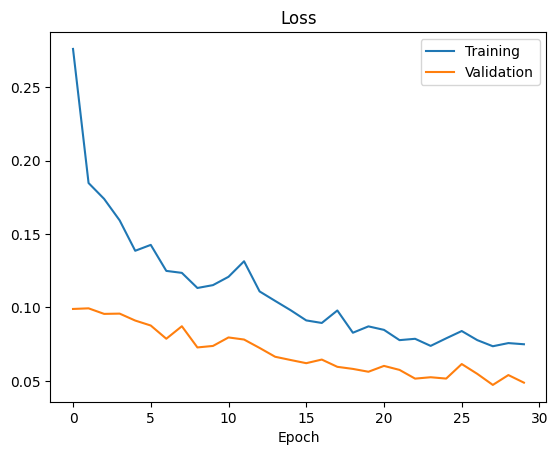

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [51]:
model.save('model.h5')

In [52]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>